In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_approximation import RBFSampler

import pygame

import gym
import sys

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
GAMMA = 0.99
ALPHA = 0.1

In [3]:
def epsilon_greedy(model, s, eps=0.1) :
    if np.random.random() < eps :
        return model.env.action_space.sample()
    else :
        values = model.predict_all_actions(s)
        return np.argmax(values)
    
def gather_samples(env, n_samples=10000) :
    samples = []
    for _ in range(n_samples):
        done = False
        s, _ = env.reset()
        n_steps = 0
        while not done:
            a = env.action_space.sample()
            sa = np.hstack((s, a))
            samples.append(sa)
            
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            n_steps += 1
    return samples

In [4]:
class Model :
    def __init__(self, env) :
        self.env = env
        self.featurizer = RBFSampler()
        
        samples = gather_samples(env)
        self.featurizer.fit(samples)
        
        dims = self.featurizer.n_components
        self.w = np.zeros(dims)
        
    def predict(self, s, a) :
        sa = np.hstack((s, a))
        x = self.featurizer.transform([sa])[0]
        return x @ self.w
    
    def grad(self, s, a) :
        sa = np.hstack((s, a))
        x = self.featurizer.transform([sa])[0]
        return x
    
    def predict_all_actions(self, s) :
        values = [self.predict(s, a) for a in range(self.env.action_space.n)]
        return values
    

In [5]:
def test_agent(model, env, n_episodes=20) :
    reward_per_episode = np.zeros(n_episodes)
    for it in range(n_episodes) :
        done = False
        episode_reward = 0
        s, _ = env.reset()
        while not done :
            a = epsilon_greedy(model, s, eps=0)
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            episode_reward += r
        reward_per_episode[it] = episode_reward
    return np.mean(reward_per_episode)    
    
# def watch_agent(model, env, eps) :
#     '''
#     plays single episode with greedy policy and renders the env
#     '''
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     fig.show()
#     done = False
#     episode_reward = 0
#     s, _ = env.reset()
#     while not done :
#         a = epsilon_greedy(model, s, eps)
#         s, r, terminated, truncated, _ = env.step(a)
#         done = terminated or truncated
#         episode_reward += r
        
#         array = env.render()
#         ax.imshow(array)
#         # fig.canvas.draw()
#         plt.pause(0.1)
        
#     print(f'Episode Reward : {episode_reward}')

def watch_agent(model, env, eps):
    """
    Plays a single episode with greedy policy and renders the environment using Pygame.
    """
    pygame.init()

    # Set up Pygame display
    screen_height, screen_width = 400, 600  # Adjust scale as needed
    screen = pygame.display.set_mode((screen_width, screen_height))
    pygame.display.set_caption("Cartpole Environment")

    done = False
    running = True
    episode_reward = 0
    s, _ = env.reset()
    clock = pygame.time.Clock()

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False  # Set the flag to False to exit the loop
                pygame.quit()

        if not done:
            a = epsilon_greedy(model, s, eps)
            s, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            episode_reward += r

            # Render the environment
            array = env.render()
            surface = pygame.surfarray.make_surface(np.rot90(array))
            screen.blit(surface, (0, 0))
            pygame.display.flip()

            clock.tick(30)  # Limit frame rate
            
    print(f'Episode Reward: {episode_reward}')
    
def print_info(episode_number, total_episodes, dct=None):
    arrow_length = 30
    progress = int((episode_number / total_episodes) * arrow_length)
    progress_bar = "=" * progress + ">"
    info_string = "\rEpisode: [{:<30}] {}/{}".format(progress_bar, episode_number, total_episodes)
    if dct is not None:
        info_string += ", {}".format(dct)
    sys.stdout.write(info_string.ljust(100))  # Adjust the total length as needed
    sys.stdout.flush()

In [17]:
env = gym.make('CartPole-v0', render_mode="rgb_array")
model = Model(env) #expensive

C:\Users\dhruv\anaconda3\envs\data_science\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\dhruv\anaconda3\envs\data_science\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [18]:
watch_agent(model, env, eps=0)

Episode Reward: 10.0


In [19]:
reward_per_epsiode = []
mse_per_epsisode = []
n_episodes = 1500

for it in range(n_episodes) :
    s, _ = env.reset()
    episode_reward = 0
    episode_se = 0
    n_steps = 0
    done = False
    while not done:
        a = epsilon_greedy(model, s, eps=0.1)
        s2, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        if done : #terminal check
            y = r
        else :
            values = model.predict_all_actions(s2)
            y = r + GAMMA * np.max(values)
                        
        #updating the model weights
        err = y - model.predict(s, a)
        model.w = model.w + ALPHA * err * model.grad(s, a)
        
        #updating metrics
        episode_se += (err ** 2)  
        episode_reward += r
        n_steps += 1
        
        #updating state
        s = s2
        
        if it > 20 and np.mean(reward_per_epsiode[-20:] == 475):  #475 for v1 and 200 for v0
            print('Early exit')
            break
            
    epsisode_mse = episode_se / n_steps
    mse_per_epsisode.append(epsisode_mse)
    reward_per_epsiode.append(episode_reward)
    print_info(it+1, n_episodes, {'mse' : epsisode_mse, 'reward' : episode_reward})

Episode: [==============================>] 1500/1500, {'mse': 12.547419556393997, 'reward': 117.0} 

In [10]:
color_pallete = sns.color_palette("muted")

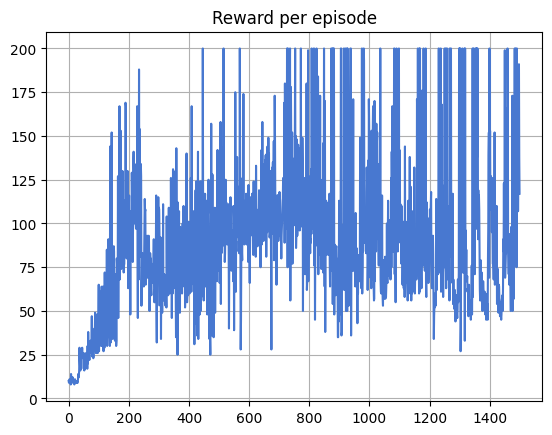

In [21]:
plt.figure()
plt.plot(reward_per_epsiode, color=color_pallete[0])
plt.grid()
plt.title('Reward per episode')
plt.show()

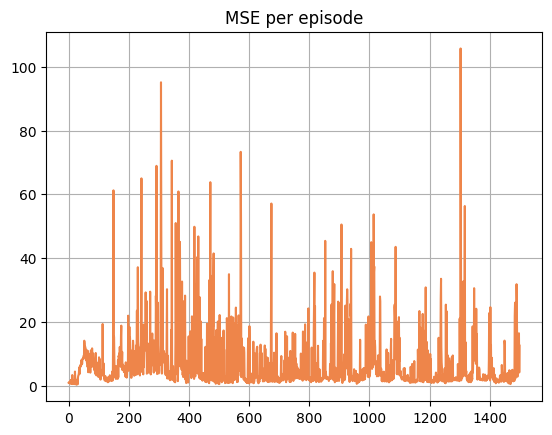

In [20]:
plt.figure()
plt.plot(mse_per_epsisode, color=color_pallete[1])
plt.grid()
plt.title('MSE per episode')
plt.show()

In [22]:
test_reward = test_agent(model, env)
print(f'Average test reward : {test_reward}')

Average test reward : 151.95


In [23]:
watch_agent(model, env, eps=0)

Episode Reward: 103.0
